In [1]:
import pydotplus 
import math
import pandas as pd
from matplotlib import pyplot
from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Теоретические задачи.
### 1.1. Ответы в листьях регрессионного дерева. Оптимальной является стратегия ответа средним значением в листе. Докажем это.
### Предположим, что мы отвечаем значением $\tilde{y}$. Минимизируем значение ошибки  MSE и найдем соответствующее значение $\tilde{y}$.
### $A(\tilde{y}) = E(y - \tilde{y})^2 = Ey^2 - 2\tilde{y}Ey + \tilde{y}^2$
### $\frac{\partial A}{\partial \tilde{y}} = -2Ey + 2\tilde{y} \Rightarrow \tilde{y} = Ey \Rightarrow$ оптимальной стратегией является ответ средним значением таргета в листе.

### 1.2. Линейные модели в деревьях. 
### Дерево приближает реальную кривую ступенчатой функцией $y = const$ таким образом, чтобы минимизировать значение ошибки. В результате в каждом листе находятся объекты, близкие к $y = const \Rightarrow$ применение линейной регрессии не даст никаких ощутимых улучшений. 
### Для того, чтобы применение регрессии имело смысл, нужно изменить принцип построения дерева - приближать не ступенчатой функцией, а ломаной линией.


### 1.3. Unsupervised Decision Tree.
### Найдем энтропию нормального распределения:
## $p(x) = \frac{1}{\sqrt{(2\pi)^n|\Sigma|}} \cdot e^{-\frac{1}{2}(x - \mu)^T\cdot \Sigma^{-1} \cdot (x - \mu)}$
## $H(x) = -\int_{-\infty}^{\infty}{p(x)ln(p(x))dx} = -\int_{-\infty}^{\infty}{p(x) \cdot (-\frac{1}{2}ln((2\pi)^n|\Sigma|) dx} - \int_{-\infty}^{\infty}{p(x) \cdot (-\frac{1}{2}(x - \mu)^T |\Sigma|^{-1}(x - \mu))dx} = \frac{1}{2}ln((2\pi)^n|\Sigma|) + \frac{1}{2}\int_{-\infty}^{\infty}{p(x)\cdot(x - \mu)^T|\Sigma|(x - \mu) dx}$
### Рассмотрим отдельно $(x - \mu)^T|\Sigma|(x - \mu) = trace((x - \mu)^T|\Sigma|(x - \mu)) = trace(|\Sigma|(x - \mu)^T(x - \mu)) = trace(E) = n \Rightarrow$
### $H(x) = \frac{1}{2}ln((2\pi)^n|\Sigma|) + \frac{n}{2} = \frac{1}{2}ln((2\pi)^n|\Sigma|) + \frac{1}{2} ln(e^n) = \frac{1}{2}ln\large((2\pi e)^n |\Sigma|$, что и требовалось доказать.

## 2. Применение решающего дерева

In [107]:
InputFile = 'german_credit.csv'
credit_data = pd.read_csv(InputFile)
data_frame = pd.DataFrame(credit_data)
data_frame

Creditability  Account Balance  Duration of Credit (month)  \
0                1                1                          18   
1                1                1                           9   
2                1                2                          12   
3                1                1                          12   
4                1                1                          12   
5                1                1                          10   
6                1                1                           8   
7                1                1                           6   
8                1                4                          18   
9                1                2                          24   
10               1                1                          11   
11               1                1                          30   
12               1                1                           6   
13               1                2                          48   
14               1                1                          18   
15               1                1                           6   
16               1                1                          11   
17               1                2                          18   
18               1                2                          36   
19               1                4                          11   
20               1                1                           6   
21               1                2                          12   
22               0                2                          36   
23               1                2                          12   
24               1                1                           6   
25               1                2                          11   
26               1                1                          12   
27               1                2                           9   
28               1                4                          15   
29               1                3                          42   
..             ...              ...                         ...   
970              0                4                          48   
971              0                2                          27   
972              0                3                          18   
973              0                1                          45   
974              0                1                           6   
975              0                1                          30   
976              0                2                          48   
977              0                1                           6   
978              0                2                          12   
979              0                1                          12   
980              0                2                          24   
981              0                4                          18   
982              0                2                          48   
983              0                1                          18   
984              0                1                          48   
985              0                4                          12   
986              0                1                          14   
987              0                1                          12   
988              0                1                          18   
989              0                2                          24   
990              0                1                          18   
991              0                2                          24   
992              0                1                          18   
993              0                1                          18   
994              0                1                          12   
995              0                1                          24   
996              0                1                          24   
997              0                4                 

In [109]:
credit_data_columns = credit_data.columns
data_columns = credit_data_columns[1:]
target_column = credit_data_columns[0]
data = credit_data[data_columns]
target = credit_data[target_column]

In [110]:
model = tree.DecisionTreeClassifier(max_depth = 3)
model.fit(data, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Рассмотрим дерево с максимальной глубиной 3:


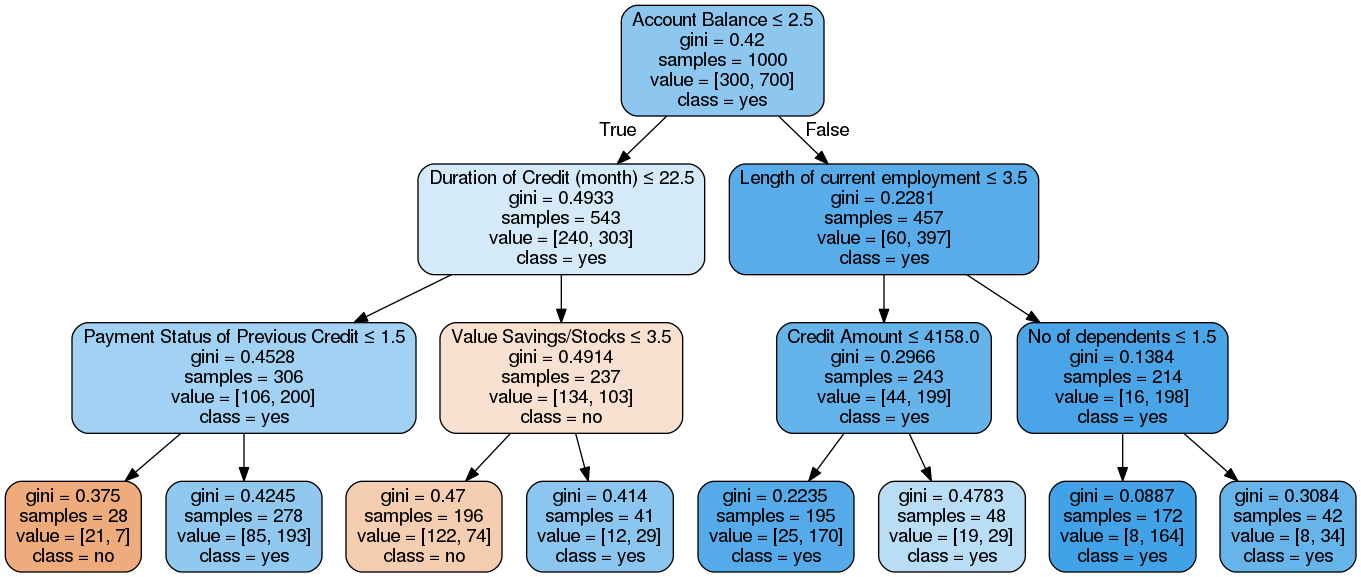

In [111]:
dot_data = tree.export_graphviz(model, out_file="small_tree.out", feature_names=data_columns, \
                                class_names={1:'yes', 0: 'no'}, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out") 
print "Рассмотрим дерево с максимальной глубиной 3:"
Image(graph.create_png())

### Выглядит довольно разумно: на первом и втором уровне учтены такие важные характеристики как состояние счета, наличие работы и срок, на который клиент собирается взять кредит. Далее учитывается кредитная история и другие признаки.

Рассмотрим дерево с максимальной глубиной 5. Оно дает более точную классификацию на обучающей выборке (см. критерий Джини), но создает высокий  риск переобучения.


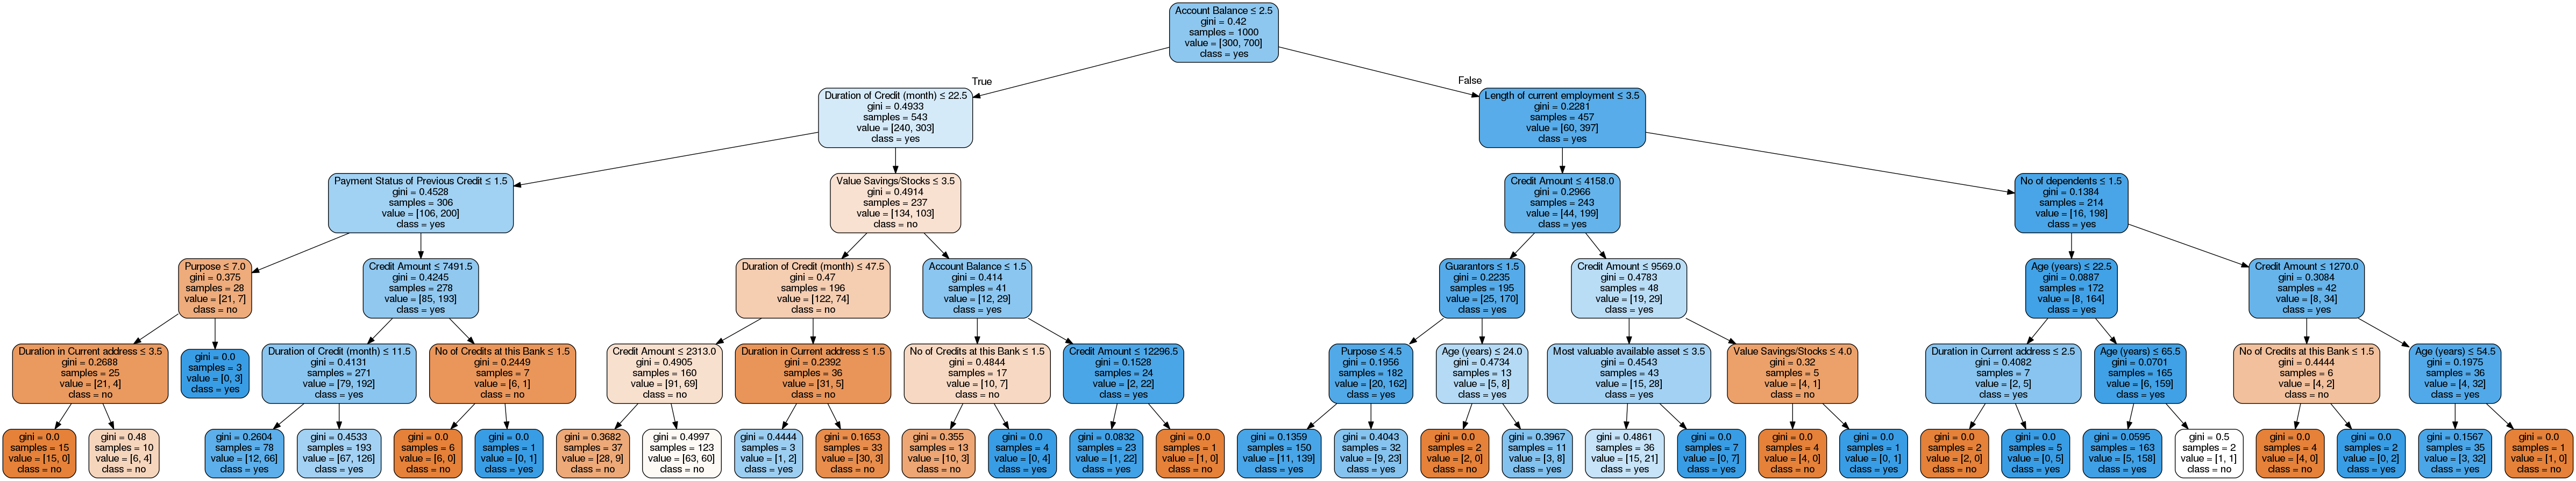

In [112]:
model = tree.DecisionTreeClassifier(max_depth = 5)
model.fit(data, target)
dot_data = tree.export_graphviz(model, out_file="big_tree.out", feature_names=data_columns, \
                                class_names={1:'yes', 0: 'no'}, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graphviz.graph_from_dot_file("big_tree.out") 
print "Рассмотрим дерево с максимальной глубиной 5. Оно дает более точную классификацию на обучающей выборке (см. критерий Джини), но создает\
 высокий  риск переобучения."
Image(graph.create_png())


In [153]:
def count_scores(train_data, train_target, test_data, test_target, N):
    score = []
    cross_score = []
    for i in range(1, N):
        model = tree.DecisionTreeClassifier(max_depth = i)
        model.fit(train_data, train_target)
        score.append(accuracy_score(model.predict(test_data), test_target))
        cross_score.append((cross_val_score(model, test_data, test_target)).mean())
    pyplot.subplot()
    pyplot.plot(np.linspace(1, N, N - 1), score, 'g', label='without cross-validation')
    pyplot.plot(np.linspace(1, N, N - 1), cross_score, label='with cross-validation')
    pyplot.grid(True)
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc = 2)
    pyplot.xlabel('max depth')
    pyplot.ylabel('accuracy')
    pyplot.ylim([0, 1])
    pyplot.show()

На обучающей выборке без кросс-валидации:


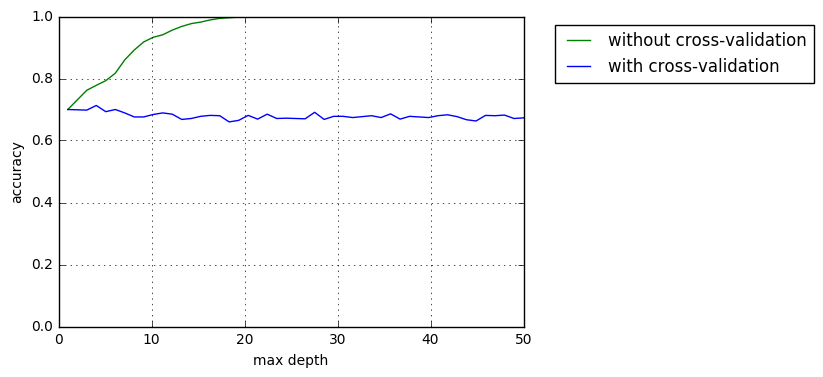

Из графика видно, что при отсутствии кросс-валидации наблюдается сильное переобучение.


In [155]:
print "На обучающей выборке без кросс-валидации:"
N = 50
score = []
train_data = credit_data[data_columns]
train_target = credit_data[target_column]
test_data = credit_data[data_columns]
test_target = credit_data[target_column]
count_scores(train_data, train_target, test_data, test_target, N)
print "Из графика видно, что при отсутствии кросс-валидации наблюдается сильное переобучение."